# Z1 Manipulator Arm

Trajectory Planning using varitop

## Imports

In [1]:
"""Temporary fix for importing modules from parent directory"""

import os
import sys

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from varitop.integrator import DelIntegrator as DI
from varitop.opti import Varitop

In [3]:
import matplotlib.pyplot as plt
import casadi as cs
import numpy as np

In [4]:
from darli.model import Functional
from darli.backend import CasadiBackend

In [5]:
from mujoco_simulator.model_builder import ModelBuilder
from mujoco_simulator.simulator import MujocoRender

In [6]:
from robot_descriptions import z1_description

## Variational Integrator

Dynamics is specified as symbolical representation of the lagrangian of the model

In [ ]:
darli_model = Functional(CasadiBackend(z1_description.URDF_PATH))
darli_model.add_body({'ee': 'link06'})

In [ ]:
nq = darli_model.nq
nv = darli_model.nv
nu = darli_model.nu

In [8]:
di = DI(
    nq = nq,
    nu = nu,
    lagrangian = darli_model.lagrangian,
)

Actuation is added to the dynamics as a function of the control

In [9]:
di.add_force(di.u)

## Optimal Control Problem  

Time intervals (nodes):

In [10]:
ns = 150  # number of shooting nodes
tf = 1.5  # [s]
dt = tf/ns

Create problem instance, configuration and control variables:

In [11]:
vp = Varitop(
    integrator=di,
    nsteps=ns,
    dt=dt,
)

Create parametric initial and final points (joint and cartesian spaces):

In [12]:
initial_configuration = vp.parameter(6)
desired_pos = vp.parameter(3)

Set of constraints is specified:

1. Initial configuration is enforced
2. Initial velocity is zero
3. Final position of the end-effector, described symbolicaly is specified
4. Terminal velocity is zero

In [13]:
q = vp.q
u = vp.u

In [16]:
# initial point (joint space)
vp.subject_to(q[:, 0] == initial_configuration)
# vp.set_initial_configuration(initial_configuration)
vp.subject_to(q[:, 0] == q[:, 1])
# Terminal point (cartesian space)
vp.subject_to(darli_model.body('ee').position(q[:, -1]) == desired_pos)
vp.subject_to(q[:, -1] == q[:, -2])

Intermidiate costs are composed as such:

1. $10^{-2}|q|^2$
2. $5\cdot 10^{-2}\;|\dot{q}|^2$
3. $5 \cdot 10^{-3}\; |u|^2$
 
Terminal cost is defined as:

1. $5\cdot10^{-2}\;|q|^2$
2. $10^{-2}\;|\dot{q}|^2$

In [17]:
# cost
cost = 0 

# stage cost 
for i in range(ns-1):
    cost += 1e-2*cs.sumsqr(q[:, i])*dt
    cost += 5e-2*cs.sumsqr((q[:, i + 1] - q[:, i])/dt)*dt
    cost += 5e-3*cs.sumsqr(u[:, i])*dt
    
# Terminal cost 
cost += 5e-2*cs.sumsqr(q[:, -1])
cost += 10e-2*cs.sumsqr((q[:, -1] - q[:, -2])/dt)

vp.set_cost(cost)

Moreover, inequatlity constraints are introduced:

1. $v_{\text{min}} \leq v \leq v_{\text{max}}$
1. $u_{\text{min}} \leq u \leq u_{\text{max}}$

In [18]:
# Limits 
# joint limits 
vp.bounded(darli_model.q_min, q, darli_model.q_max)
# velocity limits
v_max = 1.5
qdot_lims = np.full((nv), v_max)
vp.bounded(-qdot_lims,(q[:, 1:] - q[:, :-1])/dt,  qdot_lims)
# torque limits
u_max = 5
u_lims = np.full((nu), u_max) 
vp.bounded(-u_max, u,  u_max)

Define numerical values for the parameters and solve:

In [19]:
vp.set_parameter(initial_configuration,np.zeros(6))
vp.set_parameter(desired_pos,[0.2, 0.2, 0.36])

In [20]:
sol = vp.solve()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    17030
Number of nonzeros in inequality constraint Jacobian.:     3606
Number of nonzeros in Lagrangian Hessian.............:     9465

Total number of variables............................:     1806
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      915
Total number of inequality c

## Visualize

In [21]:
q_opt = vp.value(q)
u_opt = vp.value(u)
# q_opt

In [22]:
darli_model.body('ee').position(q_opt[:, -1]), vp.value(desired_pos)

(DM([0.2, 0.2, 0.36]), array([0.2 , 0.2 , 0.36]))

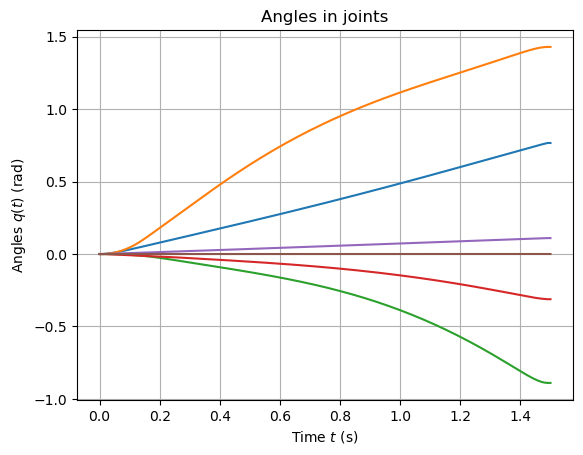

In [23]:
t = np.linspace(0, tf, ns+1)

plt.title(r'Angles in joints')
plt.plot(t, q_opt.T)
plt.grid(True)
plt.ylabel(r'Angles $q(t)$ (rad)')
plt.xlabel(r'Time $t$ (s)')
plt.show()

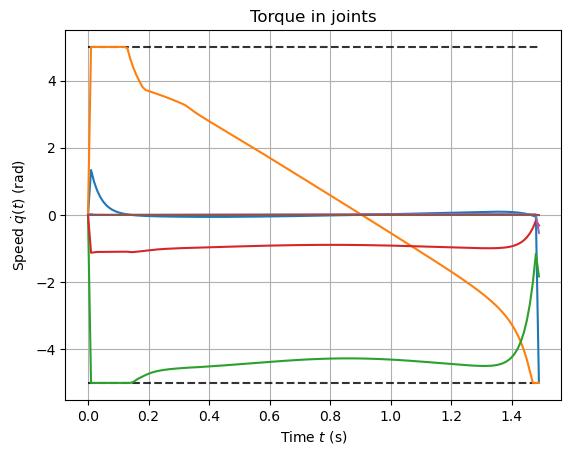

In [24]:

plt.title(r'Torque in joints')
plt.hlines(-u_max, 0, tf-dt, color = 'black', linestyle = '--', alpha = 0.8)
plt.hlines(u_max, 0, tf-dt, color = 'black', linestyle = '--', alpha = 0.8)
plt.plot(t[:-1], u_opt.T)
plt.grid(True)
plt.ylabel(r'Speed $\dot{q}(t)$ (rad)')
plt.xlabel(r'Time $t$ (s)')
plt.show()